In [123]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten,MaxPooling2D, MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from keras.optimizers import SGD,RMSprop
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE


In [2]:
from collections import Counter

In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll_Old=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))


In [4]:
yAll_Old

<xarray.DataArray 'fogdata' (time: 2418)>
array([ 8., 10., 10., ...,  6.,  9.,  9.])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31

In [5]:
yAll=xr.where(yAll_Old<12,0,1)

In [6]:
#yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
#print(yLRnf.yLR.shape[0])

wdF=yAll.where(yAll==1,drop=True)
print(wdF.shape)

(588,)


In [7]:
wdfog=yAll_Old.where(yAll_Old>11,drop=True)
print(wdfog.shape)

(588,)


In [8]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')

In [9]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [10]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [11]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [12]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [72]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)


In [73]:
y=yAll.sel(time=slice('1980-1-1','2014-12-31'))

In [74]:
t2mTsAll = t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll  = ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll  = rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll = inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll= ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll     = w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [75]:
from sklearn.preprocessing import MinMaxScaler


t1 = t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = MinMaxScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values = t1.unstack()

t1 = wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = MinMaxScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1 = rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = MinMaxScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = MinMaxScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = MinMaxScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = MinMaxScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [76]:
t2mTs=t2mTsAll.sel(time=slice('1980-1-1','2014-12-31'))
wsTs=wsTsAll.sel(time=slice('1980-1-1','2014-12-31'))
rhTs=rhTsAll.sel(time=slice('1980-1-1','2014-12-31'))
invTs=invTsAll.sel(time=slice('1980-1-1','2014-12-31'))
wTs=wTsAll.sel(time=slice('1980-1-1','2014-12-31'))
ushearTs=ushearTsAll.sel(time=slice('1980-1-1','2014-12-31'))


In [77]:
t2m_train,t2m_test,ws_train,ws_test,rh_train,rh_test,inv_train,inv_test, w_train, w_test,ushear_train, ushear_test,y_train,y_test= train_test_split( t2mTs,wsTs,rhTs,invTs, wTs,ushearTs,y,test_size=0.20, random_state=0)

In [78]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape


wstrain=ws_train.values
wstrain=wstrain[:,:,:,None]
wstrain.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape


invtrain=inv_train.values
invtrain=invtrain[:,:,:,None]
invtrain.shape

wtrain=w_train.values
wtrain=wtrain[:,:,:,None]
wtrain.shape

usheartrain=ushear_train.values
usheartrain=usheartrain[:,:,:,None]
usheartrain.shape


(1736, 18, 26, 1)

In [79]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape


wstest=ws_test.values
wstest=wstest[:,:,:,None]
wstest.shape

rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape


invtest=inv_test.values
invtest=invtest[:,:,:,None]
invtest.shape

wtest=w_test.values
wtest=wtest[:,:,:,None]
wtest.shape

usheartest=ushear_test.values
usheartest=usheartest[:,:,:,None]
usheartest.shape


(434, 18, 26, 1)

In [80]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape
ytrain.shape

(1736, 1)

In [81]:
#X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test=np.array([rhtest,wstest,invtest,wtest,usheartest])
X_test.shape

#X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain])
X_train.shape

(5, 1736, 18, 26, 1)

In [87]:
pd.DataFrame(X_train_reshape[:,:,0,0,0]).describe()

,0,1,2,3,4
count,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000
mean,0.621743,0.318631,0.725252,0.302628,0.497515
std,0.196549,0.136938,0.143581,0.072028,0.145066
min,0.062469,0.000000,0.000000,0.000000,0.000000
25%,0.483641,0.221320,0.667760,0.259568,0.407819
50%,0.639401,0.314047,0.756041,0.294733,0.496978
75%,0.771152,0.403131,0.824113,0.332610,0.594130
max,0.995334,1.000000,1.000000,1.000000,0.982124


In [86]:
pd.DataFrame(X_test_reshape[:,:,0,0,0]).describe()

,0,1,2,3,4
count,434.000000,434.000000,434.000000,434.000000,434.000000
mean,0.633313,0.331198,0.719332,0.301052,0.493127
std,0.190257,0.139282,0.149589,0.076888,0.150807
min,0.114742,0.024327,0.179627,0.030381,0.073734
25%,0.507217,0.231418,0.660915,0.256510,0.392002
50%,0.646347,0.326628,0.747519,0.296311,0.493403
75%,0.783243,0.421554,0.822154,0.331130,0.584596
max,1.000000,0.909099,0.954732,0.732886,1.000000


In [83]:
X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape
X_train_reshape.shape

(1736, 5, 18, 26, 1)

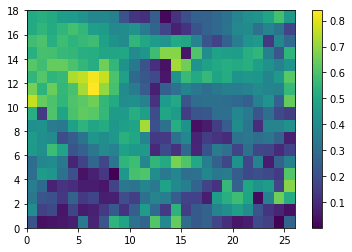

In [84]:
c = plt.pcolor(X_train_reshape[0,1,:,:,0])
plt.colorbar(c)

In [142]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 17, 25, 32)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 6, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                49216     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 49,441
Trainable params: 49,441
Non-trainable params: 0
_________________________________________________________________


In [102]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='sigmoid',padding='same',
                 input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(Conv3D(32, kernel_size=3, activation='sigmoid',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='sigmoid',padding='same'))
model.add(Conv3D(64, kernel_size=3, activation='sigmoid',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation = 'softmax'))

In [137]:
X_train_reshape.shape

(1736, 5, 18, 26, 1)

In [147]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, activation='relu',
                 input_shape=(X_train_reshape[:,0,:,:,:].shape[1],
                              X_train_reshape[:,0,:,:,:].shape[2],1)),)
#model.add(MaxPooling2D(pool_size=4))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = 'softmax'))

2
4
6
8
10


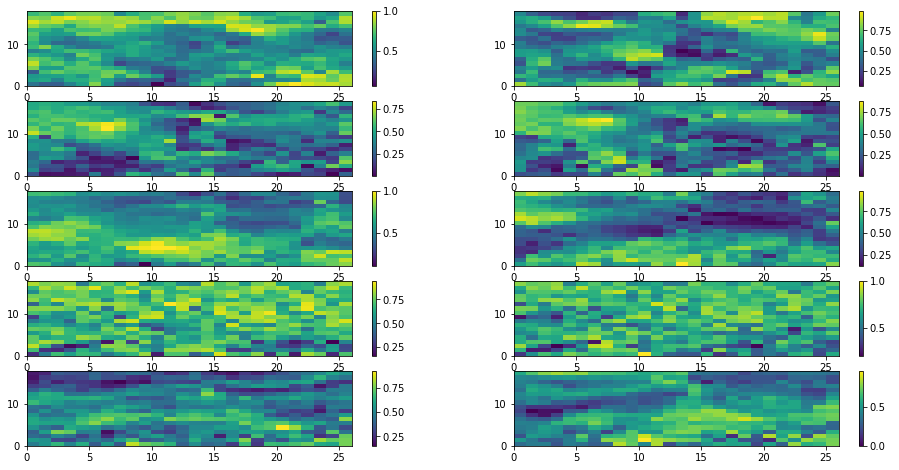

In [103]:
plt.figure(figsize=[16,8])
ii = 1
for i in range(5):

    plt.subplot(5,2,ii)
    c=plt.pcolor(X_train_reshape[0,i,:,:,0])
    plt.colorbar(c)
    
    ii = ii+1
    plt.subplot(5,2,ii)
    c1=plt.pcolor(X_test_reshape[0,i,:,:,0])
    plt.colorbar(c1)
    print(ii)
    
    ii = ii+1

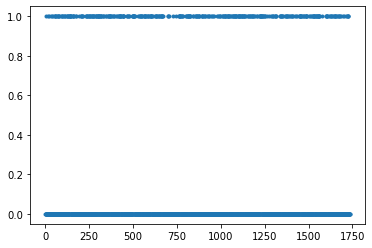

In [104]:
plt.plot(y_train,'.')

Epoch 1/5
55/55 [==============================] - 1s 3ms/step - loss: 3.4519 - acc: 0.2175
Epoch 2/5
55/55 [==============================] - 0s 2ms/step - loss: 0.5484 - acc: 0.2363
Epoch 3/5
55/55 [==============================] - 0s 2ms/step - loss: 0.5202 - acc: 0.2148
Epoch 4/5
55/55 [==============================] - 0s 2ms/step - loss: 0.5453 - acc: 0.2324
Epoch 5/5
55/55 [==============================] - 0s 2ms/step - loss: 0.5367 - acc: 0.2241


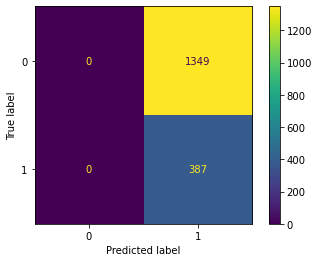

In [148]:
#opt = SGD(lr=0.01, momentum=0.9)
adam = keras.optimizers.Adam(lr=0.05)
#model.compile(optimizer=adam, loss='binary_crossentropy',  metrics='accuracy')

model.compile(optimizer=adam, loss='binary_crossentropy',  metrics='acc')

history = model.fit(X_train_reshape[:,0,:], ytrain, epochs=5)
yy_test = model.predict(X_train_reshape[:,0,:])
#print(yy_test)
cm=confusion_matrix(y_train, yy_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 


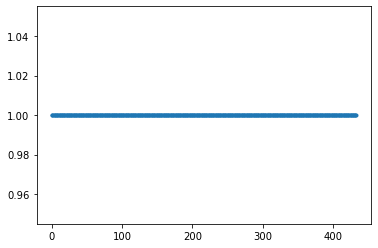

In [99]:
plt.plot(yy_test,'.')

Epoch 1/10
85/85 [==============================] - 10s 111ms/step - loss: 1.0715 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.2097
Epoch 2/10
85/85 [==============================] - 7s 79ms/step - loss: 0.6936 - accuracy: 0.5084 - val_loss: 0.6909 - val_accuracy: 0.2097
Epoch 3/10
85/85 [==============================] - 7s 86ms/step - loss: 0.6934 - accuracy: 0.4944 - val_loss: 0.7016 - val_accuracy: 0.2097
Epoch 4/10
85/85 [==============================] - 7s 78ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6876 - val_accuracy: 0.2097
Epoch 5/10
85/85 [==============================] - 7s 84ms/step - loss: 0.6934 - accuracy: 0.5046 - val_loss: 0.6942 - val_accuracy: 0.2097
Epoch 6/10
85/85 [==============================] - 7s 79ms/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6957 - val_accuracy: 0.2097
Epoch 7/10
85/85 [==============================] - 7s 77ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6907 - val_accuracy: 0.2097
Epoch 8/10


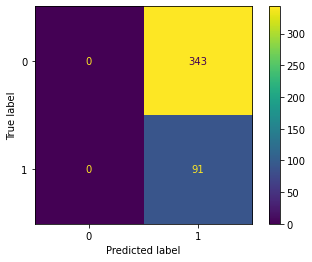

In [86]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',
                 input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(units=1, activation = 'softmax'))

opt = SGD(lr=0.01, momentum=0.9)

adam = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=adam, loss='binary_crossentropy',  metrics='accuracy')
history = model.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=10)
yy_test = model.predict(X_test_reshape)
#print(yy_test)
cm=confusion_matrix(y_test, yy_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("model Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 256 lr=0.01") 

In [ ]:
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Epoch 1/10
85/85 [==============================] - 13s 132ms/step - loss: 3.2664 - accuracy: 0.4941 - val_loss: 0.7148 - val_accuracy: 0.2097
Epoch 2/10
85/85 [==============================] - 10s 115ms/step - loss: 0.7047 - accuracy: 0.4900 - val_loss: 0.5659 - val_accuracy: 0.2097
Epoch 3/10
85/85 [==============================] - 10s 118ms/step - loss: 0.7114 - accuracy: 0.4929 - val_loss: 0.8743 - val_accuracy: 0.2097
Epoch 4/10
85/85 [==============================] - 10s 118ms/step - loss: 0.7033 - accuracy: 0.5076 - val_loss: 0.5861 - val_accuracy: 0.2097
Epoch 5/10
85/85 [==============================] - 10s 116ms/step - loss: 0.7075 - accuracy: 0.5017 - val_loss: 0.6818 - val_accuracy: 0.2097
Epoch 6/10
85/85 [==============================] - 10s 116ms/step - loss: 0.6945 - accuracy: 0.4994 - val_loss: 0.7126 - val_accuracy: 0.2097
Epoch 7/10
85/85 [==============================] - 10s 117ms/step - loss: 0.6942 - accuracy: 0.5078 - val_loss: 0.6880 - val_accuracy: 0.2097

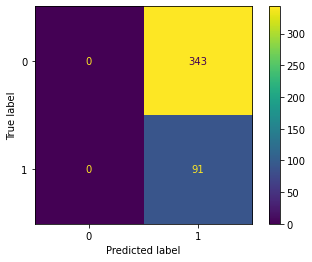

In [46]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(units=1, activation = 'softmax'))

opt = RMSprop(lr=0.01, momentum=0.9)

#adam = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy',  metrics='accuracy')
history = model.fit(X_train_reshape2, ytrain, validation_data=(X_test_reshape, ytest), epochs=10)
yy_test = model.predict(X_test_reshape)

cm=confusion_matrix(y_test, yy_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

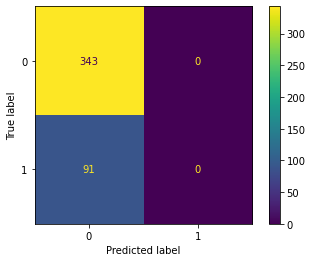

In [ ]:
t2mTst=t2mTsAll.sel(time=slice('2015-1-1','2018-12-31'))
wsTst=wsTsAll.sel(time=slice('2015-1-1','2018-12-31'))
rhTst=rhTsAll.sel(time=slice('2015-1-1','2018-12-31'))
invTst=invTsAll.sel(time=slice('2015-1-1','2018-12-31'))
wTst=wTsAll.sel(time=slice('2015-1-1','2018-12-31'))
ushearTst=ushearTsAll.sel(time=slice('2015-1-1','2018-12-31'))
yt=yAll.sel(time=slice('2015-1-1','2018-12-31'))

In [ ]:
t2m_t=t2mTst.values
t2m_t=t2m_t[:,:,:,None]
t2m_t.shape


ws_t=wsTst.values
ws_t=ws_t[:,:,:,None]
ws_t.shape

rh_t=rhTst.values
rh_t=rh_t[:,:,:,None]
rh_t.shape


inv_t=invTst.values
inv_t=inv_t[:,:,:,None]
inv_t.shape

w_t=wTst.values
w_t=w_t[:,:,:,None]
w_t.shape

ushear_t=ushearTst.values
ushear_t=ushear_t[:,:,:,None]
ushear_t.shape


In [ ]:
#X_t=np.array([t2m_t,rh_t,ws_t,inv_t,w_t,ushear_t,ao_t,eu_t])
X_t=np.array([rh_t,ws_t,inv_t,w_t,ushear_t])
X_t.shape


In [ ]:
X_t_reshape = np.einsum('lkija->klija',X_t)
X_t_reshape.shape

In [ ]:
yLRt=model.predict(X_t_reshape)

In [ ]:
testcorr = np.corrcoef(yLRt[:,0],yt)[0,1]

#acc_svr       = round(regLin.score(Xt, yt) * 100, 2)

#print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)

plt.title(' CNN corr = %f'%testcorr)

plt.plot(yt,yLRt[:,0],'+')


In [ ]:
t2mAll=t2mTs.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTs.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTs.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTs.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTs.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTs.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape


In [ ]:
X_All=np.array([rhAll,wsAll,invAll,wAll,ushearAll])
X_All.shape

X_All_reshape = np.einsum('lkija->klija',X_All)
X_All_reshape.shape

In [ ]:
yLR=model.predict(X_All_reshape)

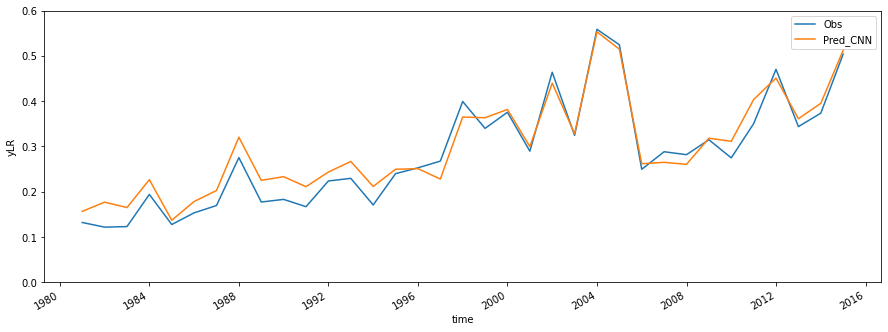

In [29]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR[:,0])}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataCNN_1.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_CNN')
#dump(y,'TS1dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()


In [30]:
ynf=y.where(y<0.040, drop=True)
print(ynf.shape[0])

yint1=y.where(y>=0.04,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
print(yintf.shape[0])

yWd=y.where(y>=0.48, drop=True)
print(yWd.shape[0])

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
print(yLRnf.yLR.shape[0])

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>=0.04,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)
print(yLRintf.yLR.shape[0])

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>=0.48,drop=True)
print(yLRWd.yLR.shape[0])

print((ynf.shape[0]+yintf.shape[0]+yWd.shape[0]))
print((yLRnf.yLR.shape[0]+yLRintf.yLR.shape[0]+yLRWd.yLR.shape[0]))

123
1569
478
25
1720
425
2170
2170


Text(0.5, 1.0, 'CNN')

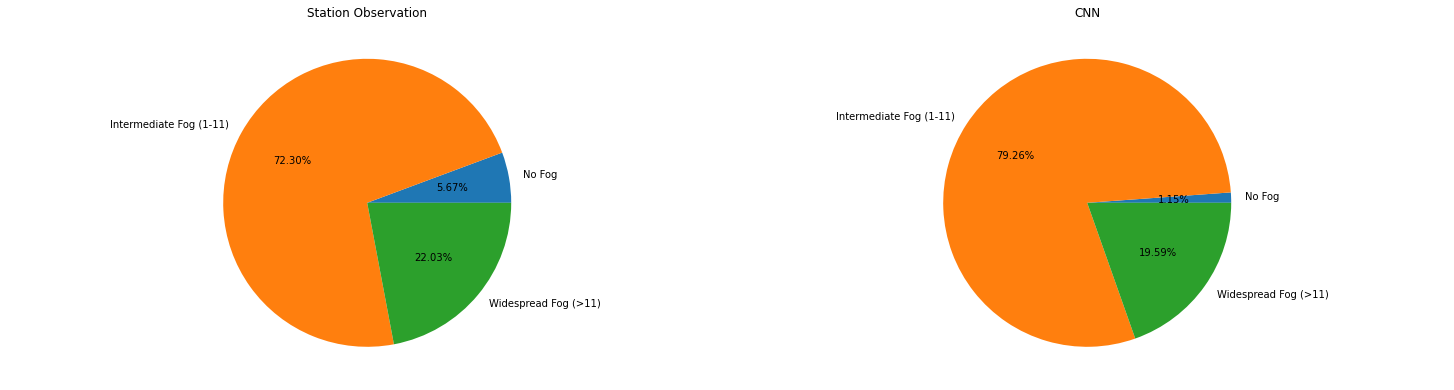

In [31]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')

In [32]:
pie1dataObs = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
pie1dataLR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
#dump(pie1dataObs, 'pie1dataObs_1.joblib') 
dump(pie1dataLR,'pie1dataCNN_1.joblib')

['pie1dataCNN_1.joblib']

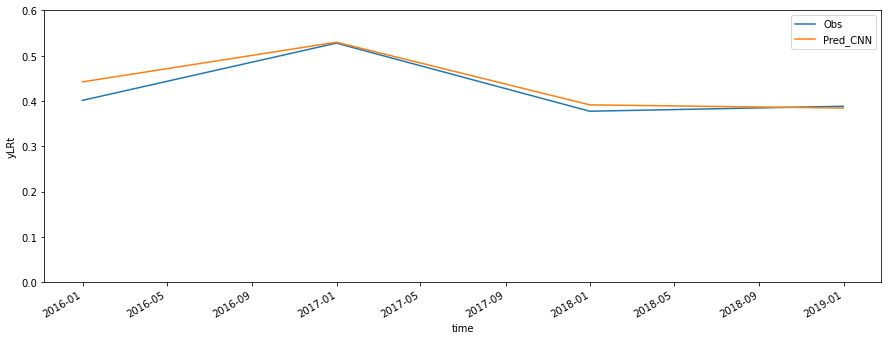

In [33]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt[:,0])}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataCNN_1.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_CNN')
##dump(yt,'TS2dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()

In [34]:
ynft=yt.where(yt<0.040, drop=True)
print(ynft.shape[0])

yint1t=yt.where(yt>=0.04,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
print(yintft.shape[0])

yWdt=yt.where(yt>=0.48, drop=True)
print(yWdt.shape[0])

print((ynft.shape[0]+yintft.shape[0]+yWdt.shape[0]))

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)
print(yLRnft.yLRt.shape[0])

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>=0.04,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
print(yLRintft.yLRt.shape[0])

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>=0.48,drop=True)
print(yLRWdt.yLRt.shape[0])

print((yLRnft.yLRt.shape[0]+yLRintft.yLRt.shape[0]+yLRWdt.yLRt.shape[0]))

2
136
110
248
0
146
102
248


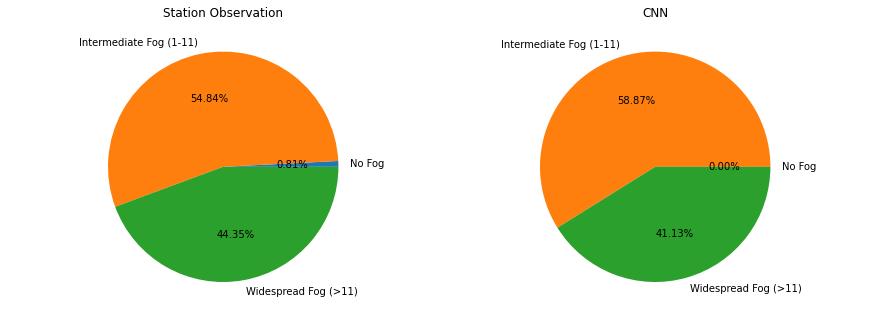

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')
plt.show()

In [36]:
pie1dataObs = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
pie1dataLR = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
#dump(pie1dataObs, 'pie2dataObs_1.joblib') 
dump(pie1dataLR,'pie2dataCNN_1.joblib')

['pie2dataCNN_1.joblib']